In [10]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

In [11]:
RATIOS = ['L1',
       'L2', 'L3', 'NCL_CF', 'CASH_TA', 'INV_COGS', 'CC_SAL', 'TL_COST',
       'CL_COST', 'SAL_TA', 'EQ_TA', 'EQ_TL', 'CL_CC', 'LTC_NCA', 'TZ',
       'CF_TL', 'CL_TA', 'NCL_TA', 'EBT_REV', 'ROS', 'EAT_REV', 'ROA', 'ROE',
       'CF_TA', 'CF_SAL', 'LABOR_EAT', 'LABOR_REV']

PRIMARY_VALUES = [
    'CA', 'CASH',
       'CL', 'EQ', 'NCL', 'TA', 'TL', 'CC', 'INV', 'CF_NETTO', 'CF_SELFFIN',
       'REV', 'VA', 'OE', 'EAT', 'EBIT', 'SAL', 'COST', 'INT'
]


REDUCED_FEATURE_SET = ['L1', 'L3', 'EQ_TA', 'CL_CC', 'LTC_NCA', 'TZ', 'CF_TL', 'CL_TA', 'ROS', 'ROA', 'ROE']

SKNACE_ONE_HOT = ['sknace_C', 'sknace_F', 'sknace_G', 'sknace_H', 'sknace_M', 'sknace_other']

In [12]:
training_raw = pd.read_csv('../../DATA/FINAL/final/training_sample.csv')
testing_raw = pd.read_csv('../../DATA/FINAL/final/testing_sample.csv')
training_raw.shape, testing_raw.shape

((7188, 107), (1797, 107))

In [13]:
SAL_CLASSES = training_raw['sal_class'].unique()
SKNACE_GROUPS = training_raw['sknace_division_normalized'].unique()

In [14]:
training_filled = training_raw.copy()
testing_filled = testing_raw.copy()

In [20]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline




Q = training_filled.query('combined_issue_criteria_3y_off == 1')['entity_id'].nunique()

control_group_ratio = 1.5

training_balanced = (
    pd.concat(
        [
            training_filled.query('combined_issue_criteria_3y_off == 0').sample(int(Q * control_group_ratio)),
            training_filled.query('combined_issue_criteria_3y_off == 1').sample(Q),
        ], axis = 0
    )
)



Q_test = testing_filled.query('combined_issue_criteria_3y_off == 1')['entity_id'].nunique()

testing_balanced = (
    pd.concat(
        [
            testing_filled.query('combined_issue_criteria_3y_off == 0').sample(int(Q_test * control_group_ratio)),
            testing_filled.query('combined_issue_criteria_3y_off == 1').sample(Q_test),
        ], axis = 0
    )
)


X_train_balanced = training_balanced[REDUCED_FEATURE_SET].values
y_train_balanced = training_balanced['combined_issue_criteria_3y_off'].values

X_test_balanced = testing_balanced[REDUCED_FEATURE_SET].values
y_test_balanced = testing_balanced['combined_issue_criteria_3y_off'].values

X_train_imbalanced = training_filled[REDUCED_FEATURE_SET].values
y_train_imbalanced = training_filled['combined_issue_criteria_3y_off'].values

X_test_imbalanced = testing_filled[REDUCED_FEATURE_SET].values
y_test_imbalanced = testing_filled['combined_issue_criteria_3y_off'].values

X_train_valid_balanced, X_valid_valid_balanced, y_train_valid_balanced, y_valid_valid_balanced = train_test_split(
    X_train_balanced, y_train_balanced, test_size=0.2, random_state=42)


X_train_valid_imbalanced, X_valid_valid_imbalanced, y_train_valid_imbalanced, y_valid_valid_imbalanced = train_test_split(
    X_train_imbalanced, y_train_imbalanced, test_size=0.2, random_state=42)


In [21]:
print(X_train_balanced.shape, X_test_balanced.shape)
print(X_train_imbalanced.shape, X_test_imbalanced.shape)

(1750, 11) (430, 11)
(7188, 11) (1797, 11)


In [22]:
print('\nTEST')
print(pd.Series(y_test_balanced).value_counts())
print(pd.Series(y_test_imbalanced).value_counts())

print('\nTRAIN')
print(pd.Series(y_train_balanced).value_counts())
print(pd.Series(y_train_imbalanced).value_counts())

print('\nTRAIN W VALID')
print(pd.Series(y_train_valid_balanced).value_counts())
print(pd.Series(y_train_valid_imbalanced).value_counts())

print('\nVALID')
print(pd.Series(y_valid_valid_balanced).value_counts())
print(pd.Series(y_valid_valid_imbalanced).value_counts())


TEST
0.0    258
1.0    172
dtype: int64
0.0    1625
1.0     172
dtype: int64

TRAIN
0.0    1050
1.0     700
dtype: int64
0.0    6488
1.0     700
dtype: int64

TRAIN W VALID
0.0    842
1.0    558
dtype: int64
0.0    5183
1.0     567
dtype: int64

VALID
0.0    208
1.0    142
dtype: int64
0.0    1305
1.0     133
dtype: int64


In [23]:

from sklearn.feature_selection import RFECV
from sklearn.metrics import f1_score
from imblearn.metrics import specificity_score



def eval(real, pred, label):
    print(f'real_positives = {sum(real)}, total = {len(real)}')
    recall = recall_score(real, pred)
    accuracy = accuracy_score(real, pred)
    print(f"{label} Accuracy:", accuracy)
    print(f"{label} Precision:", precision_score(real, pred))
    print(f"{label} Recall:", recall)
    print(f"{label} Specificity:", specificity_score(real, pred))
    print(f"{label} F1 Score:", f1_score(real, pred))

    cm = confusion_matrix(real, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(label)
    plt.show()

## Random Forest Classifier

In [26]:
FINAL_FEATURE_SET = ['L3', 'EQ_TA', 'LTC_NCA', 'TZ', 'CF_TL', 'CL_TA', 'ROS', 'ROA', 'ROE']

In [28]:

Q = training_filled.query('combined_issue_criteria_3y_off == 1')['entity_id'].nunique()

control_group_ratio = 1.5

training_balanced = (
    pd.concat(
        [
            training_filled.query('combined_issue_criteria_3y_off == 0').sample(int(Q * control_group_ratio)),
            training_filled.query('combined_issue_criteria_3y_off == 1').sample(Q),
        ], axis = 0
    )
)



Q_test = testing_filled.query('combined_issue_criteria_3y_off == 1')['entity_id'].nunique()

testing_balanced = (
    pd.concat(
        [
            testing_filled.query('combined_issue_criteria_3y_off == 0').sample(int(Q_test * control_group_ratio)),
            testing_filled.query('combined_issue_criteria_3y_off == 1').sample(Q_test),
        ], axis = 0
    )
)


X_train_balanced = training_balanced[FINAL_FEATURE_SET].values
y_train_balanced = training_balanced['combined_issue_criteria_3y_off'].values

X_test_balanced = testing_balanced[FINAL_FEATURE_SET].values
y_test_balanced = testing_balanced['combined_issue_criteria_3y_off'].values

X_train_imbalanced = training_filled[FINAL_FEATURE_SET].values
y_train_imbalanced = training_filled['combined_issue_criteria_3y_off'].values

X_test_imbalanced = testing_filled[FINAL_FEATURE_SET].values
y_test_imbalanced = testing_filled['combined_issue_criteria_3y_off'].values



# X_train_valid_balanced, X_valid_valid_balanced, y_train_valid_balanced, y_valid_valid_balanced = train_test_split(
#     X_train_balanced, y_train_balanced, test_size=0.2, random_state=42)


X_train_valid_imbalanced, X_valid_valid_imbalanced, y_train_valid_imbalanced, y_valid_valid_imbalanced = train_test_split(
    X_train_imbalanced, y_train_imbalanced, test_size=0.2, random_state=42)


from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

# Assuming X_train_valid_imbalanced and y_train_valid_imbalanced are already defined
# Count the number of samples in each class
counter = Counter(y_train_valid_imbalanced)
print(f"Original class distribution: {counter}")

# Calculate the number of samples needed for the majority class (class 0) to achieve a 3:2 ratio
minority_class_count = counter[1]
desired_majority_class_count = (minority_class_count * 3) // 2

# Define the sampling strategy for RandomUnderSampler
sampling_strategy = {0: desired_majority_class_count, 1: minority_class_count}

# Apply RandomUnderSampler with the defined sampling strategy
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_train_valid_balanced, y_train_valid_balanced = rus.fit_resample(X_train_valid_imbalanced, y_train_valid_imbalanced)



Original class distribution: Counter({0.0: 5183, 1.0: 567})


In [29]:
print('\nTEST')
print(pd.Series(y_test_balanced).value_counts())
print(pd.Series(y_test_imbalanced).value_counts())

print('\nTRAIN')
print(pd.Series(y_train_balanced).value_counts())
print(pd.Series(y_train_imbalanced).value_counts())

print('\nTRAIN W VALID')
print(pd.Series(y_train_valid_balanced).value_counts())
print(pd.Series(y_train_valid_imbalanced).value_counts())

print('\nVALID')
print(pd.Series(y_valid_valid_balanced).value_counts())
print(pd.Series(y_valid_valid_imbalanced).value_counts())


TEST
0.0    258
1.0    172
dtype: int64
0.0    1625
1.0     172
dtype: int64

TRAIN
0.0    1050
1.0     700
dtype: int64
0.0    6488
1.0     700
dtype: int64

TRAIN W VALID
0.0    850
1.0    567
dtype: int64
0.0    5183
1.0     567
dtype: int64

VALID
0.0    208
1.0    142
dtype: int64
0.0    1305
1.0     133
dtype: int64


In [30]:
from sklearn.model_selection import GridSearchCV

In [39]:

# first generation
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000],
    'gamma': [1e-0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
}

from sklearn.svm import SVC


# Create an XGBoost classifier
svm_classifier = SVC(kernel='rbf', random_state=37)

grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=5, n_jobs=4, verbose=10, scoring='f1')
grid_search.fit(X_train_balanced, y_train_balanced)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5, estimator=SVC(random_state=37), n_jobs=4,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000],
                         'gamma': [1.0, 0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06,
                                   1e-07]},
             scoring='f1', verbose=10)

In [42]:
grid_search.best_params_

{'C': 100000, 'gamma': 1e-05}

In [43]:
# Extract grid search results
cv_results = pd.DataFrame(grid_search.cv_results_)

# Display grid search results
# print(cv_results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']])

# Sort by rank to see the best combinations first
sorted_cv_results = cv_results.sort_values(by='rank_test_score')
sorted_cv_results.head(40)




,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
61,0.497767,0.067843,0.057406,0.005994,100000,0.00001,"{'C': 100000, 'gamma': 1e-05}",0.633205,0.643411,0.591667,0.671937,0.625000,0.633044,0.026065,1
52,0.421275,0.078771,0.061062,0.009784,10000,0.0001,"{'C': 10000, 'gamma': 0.0001}",0.619048,0.640625,0.582278,0.666667,0.622568,0.626237,0.027709,2
60,2.976599,0.972548,0.061013,0.004239,100000,0.0001,"{'C': 100000, 'gamma': 0.0001}",0.607287,0.632411,0.544681,0.666667,0.610039,0.612217,0.039907,3
51,1.882214,0.281103,0.055234,0.004690,10000,0.001,"{'C': 10000, 'gamma': 0.001}",0.577236,0.624506,0.582278,0.666667,0.607004,0.611538,0.032437,4
59,14.251099,2.794526,0.055830,0.006760,100000,0.001,"{'C': 100000, 'gamma': 0.001}",0.600791,0.599190,0.588235,0.661417,0.602317,0.610390,0.025990,5
43,0.260307,0.026178,0.061911,0.006799,1000,0.001,"{'C': 1000, 'gamma': 0.001}",0.576132,0.632813,0.553191,0.639004,0.610687,0.602365,0.033000,6
62,0.189163,0.011157,0.061176,0.005602,100000,0.000001,"{'C': 100000, 'gamma': 1e-06}",0.613546,0.626506,0.565217,0.620087,0.585366,0.602144,0.023197,7
53,0.178277,0.019040,0.060838,0.005434,10000,0.00001,"{'C': 10000, 'gamma': 1e-05}",0.608000,0.620968,0.558952,0.614035,0.600000,0.600391,0.021839,8
44,0.154127,0.005087,0.062084,0.004407,1000,0.0001,"{'C': 1000, 'gamma': 0.0001}",0.592000,0.622047,0.556522,0.615385,0.592000,0.595591,0.022995,9
34,0.177144,0.009508,0.056260,0.004952,100,0.01,"{'C': 100, 'gamma': 0.01}",0.555102,0.600791,0.561702,0.634921,0.582677,0.587038,0.028854,10


In [38]:
head = cv_results.sort_values(by='rank_test_score').head(8)


new_params = dict()

for param_name in cv_results.columns:
    if 'param_' in param_name:
        new_params[param_name] = list(head[param_name].unique())

display(new_params)      


{'param_C': [10000, 1000, 100], 'param_gamma': [0.0001, 0.001, 1e-05, 0.01]}

## VALIDATION

In [40]:
pd.Series(y_valid_valid_imbalanced).value_counts()

0.0    1305
1.0     133
dtype: int64

In [44]:
def predict_w_threshold(estimator, X, threshold):
    proba = estimator.predict_proba(X)[:, 1]
    return (proba >= threshold).astype(int)

real_positives = 133.0, total = 1438
SEMIFINAL MODEL IMBALANCED Accuracy: 0.8226703755215578
SEMIFINAL MODEL IMBALANCED Precision: 0.2852112676056338
SEMIFINAL MODEL IMBALANCED Recall: 0.6090225563909775
SEMIFINAL MODEL IMBALANCED Specificity: 0.8444444444444444
SEMIFINAL MODEL IMBALANCED F1 Score: 0.3884892086330936


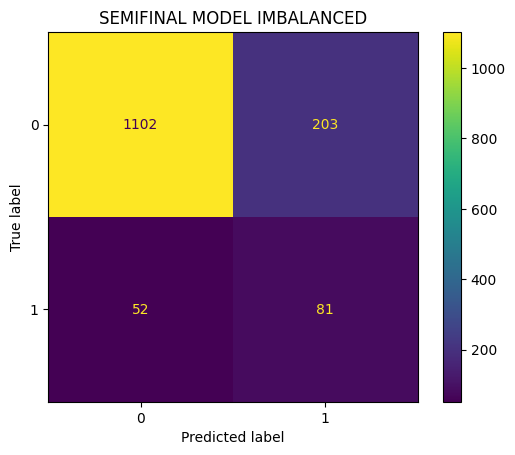

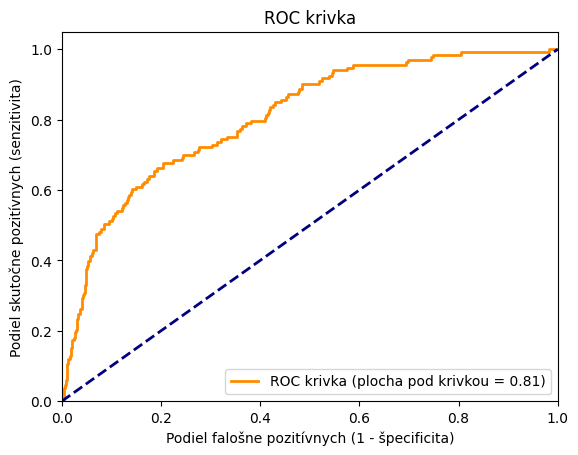

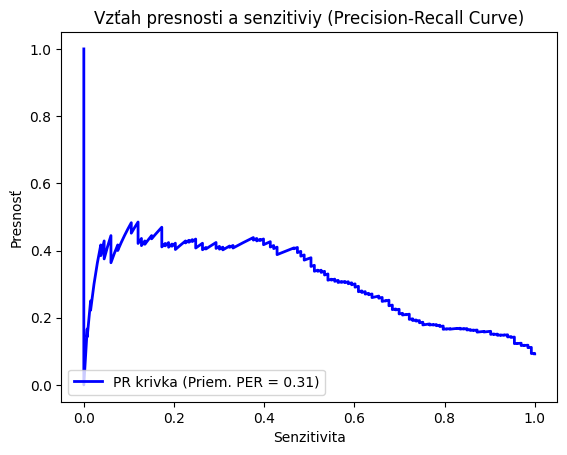

Threshold for 70% recall: 0.028087630840129604
Actual recall: 1.00
real_positives = 133.0, total = 1438
FINAL MODEL IMBALANCED Accuracy: 0.7357440890125174
FINAL MODEL IMBALANCED Precision: 0.21478060046189376
FINAL MODEL IMBALANCED Recall: 0.6992481203007519
FINAL MODEL IMBALANCED Specificity: 0.7394636015325671
FINAL MODEL IMBALANCED F1 Score: 0.3286219081272085


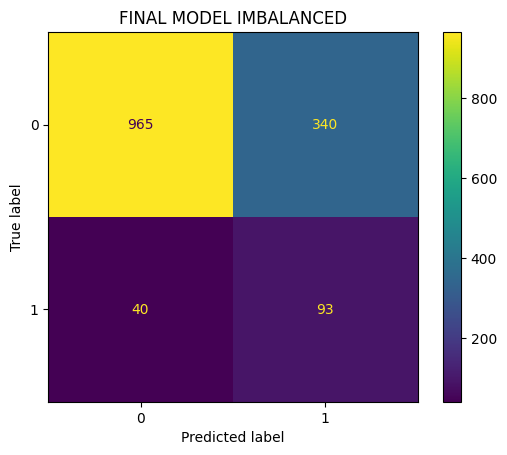

In [46]:

# Create an XGBoost classifier

svm_classifier = SVC(kernel='rbf', random_state=13, C = 10000, gamma=0.0001, probability=True)


svm_classifier.fit(X_train_valid_balanced, y_train_valid_balanced)

eval(y_valid_valid_imbalanced, svm_classifier.predict(X_valid_valid_imbalanced), 'SEMIFINAL MODEL IMBALANCED')

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score

y_probs = svm_classifier.predict_proba(X_valid_valid_imbalanced)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_valid_valid_imbalanced, y_probs)

# Compute the AUC score
roc_auc = roc_auc_score(y_valid_valid_imbalanced, y_probs)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC krivka (plocha pod krivkou = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Podiel falošne pozitívnych (1 - špecificita)')
plt.ylabel('Podiel skutočne pozitívnych (senzitivita)')
plt.title('ROC krivka')
plt.legend(loc='lower right')
plt.show()

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_valid_valid_imbalanced, y_probs)

# Compute average precision score
average_precision = average_precision_score(y_valid_valid_imbalanced, y_probs)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PR krivka (Priem. PER = {average_precision:.2f})')
plt.xlabel('Senzitivita')
plt.ylabel('Presnosť')
plt.title('Vzťah presnosti a senzitiviy (Precision-Recall Curve)')
plt.legend(loc='lower left')
plt.show()




# Find the threshold that achieves the target recall (70%)
target_recall = 0.70
threshold = thresholds[np.argmax(recall >= target_recall)]

# Predict using the new threshold
y_pred = (y_probs >= threshold).astype(int)

# Calculate the recall score with the new threshold
actual_recall = recall_score(y_valid_valid_imbalanced, y_pred)


print(f"Threshold for 70% recall: {threshold}")
print(f"Actual recall: {actual_recall:.2f}")




eval(y_valid_valid_imbalanced, predict_w_threshold(svm_classifier, X_valid_valid_imbalanced, 0.4), 'FINAL MODEL IMBALANCED')

## FINAL TESTING

real_positives = 700.0, total = 1750
FINAL MODEL TRAIN BALANCED Accuracy: 0.7434285714285714
FINAL MODEL TRAIN BALANCED Precision: 0.7277676950998185
FINAL MODEL TRAIN BALANCED Recall: 0.5728571428571428
FINAL MODEL TRAIN BALANCED Specificity: 0.8571428571428571
FINAL MODEL TRAIN BALANCED F1 Score: 0.6410871302957634


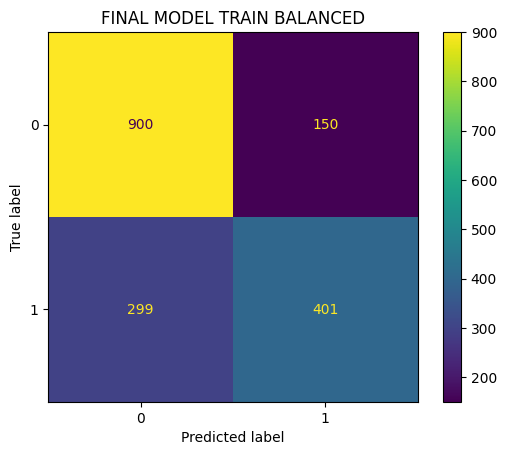

real_positives = 172.0, total = 430
FINAL MODEL BALANCED Accuracy: 0.7162790697674418
FINAL MODEL BALANCED Precision: 0.6811594202898551
FINAL MODEL BALANCED Recall: 0.5465116279069767
FINAL MODEL BALANCED Specificity: 0.8294573643410853
FINAL MODEL BALANCED F1 Score: 0.6064516129032258


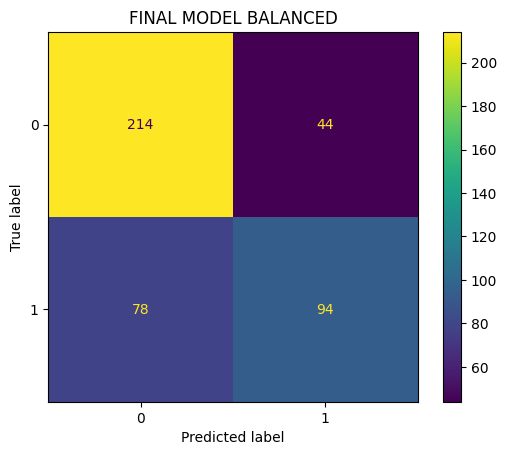

real_positives = 172.0, total = 1797
FINAL MODEL IMBALANCED Accuracy: 0.8263772954924875
FINAL MODEL IMBALANCED Precision: 0.2865853658536585
FINAL MODEL IMBALANCED Recall: 0.5465116279069767
FINAL MODEL IMBALANCED Specificity: 0.856
FINAL MODEL IMBALANCED F1 Score: 0.376


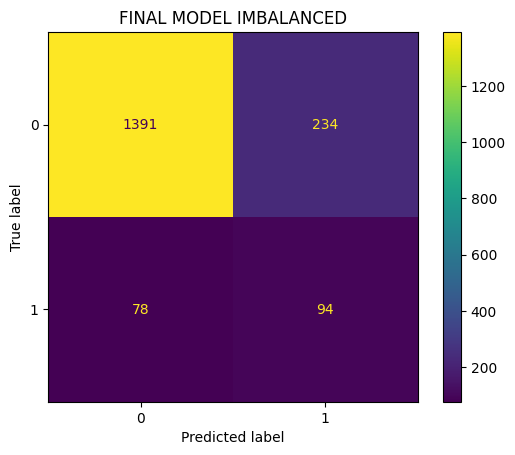

real_positives = 172.0, total = 430
FINAL MODEL BALANCED Accuracy: 0.7046511627906977
FINAL MODEL BALANCED Precision: 0.6190476190476191
FINAL MODEL BALANCED Recall: 0.6802325581395349
FINAL MODEL BALANCED Specificity: 0.7209302325581395
FINAL MODEL BALANCED F1 Score: 0.6481994459833795


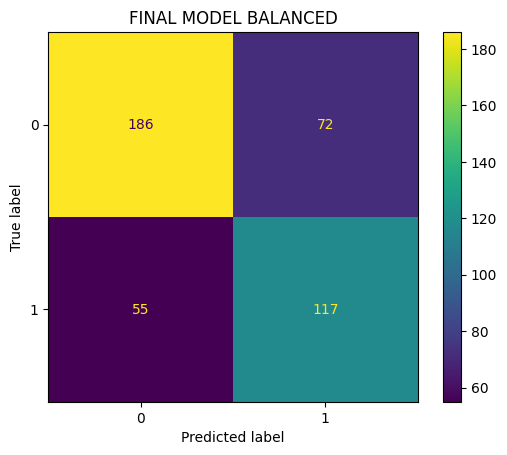

real_positives = 172.0, total = 1797
FINAL MODEL IMBALANCED Accuracy: 0.7367835281023929
FINAL MODEL IMBALANCED Precision: 0.21869158878504674
FINAL MODEL IMBALANCED Recall: 0.6802325581395349
FINAL MODEL IMBALANCED Specificity: 0.7427692307692307
FINAL MODEL IMBALANCED F1 Score: 0.33097595473833097


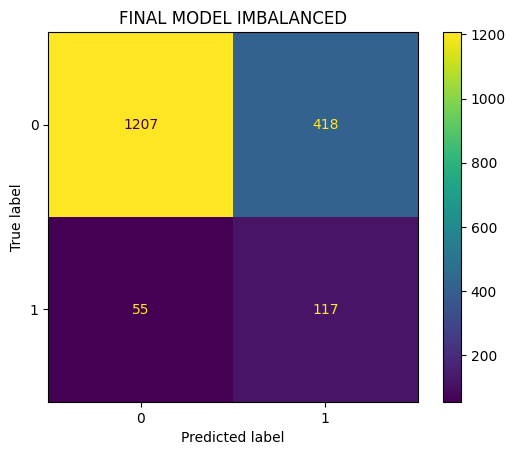

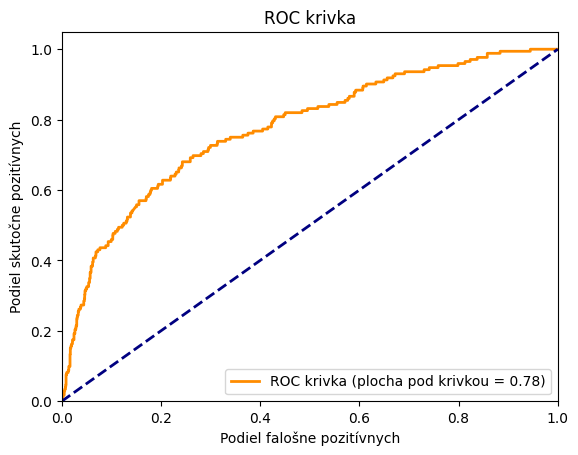

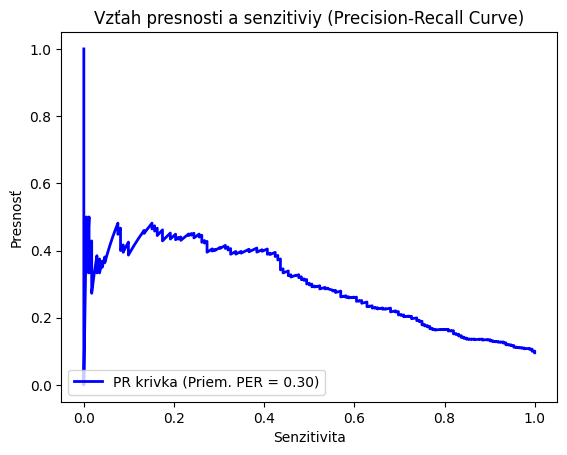

In [47]:
rf_final = SVC(kernel='rbf', random_state=13, C = 10000, gamma=0.0001, probability=True)

rf_final.fit(X_train_balanced, y_train_balanced)


eval(y_train_balanced, rf_final.predict(X_train_balanced), 'FINAL MODEL TRAIN BALANCED')
eval(y_test_balanced, rf_final.predict(X_test_balanced), 'FINAL MODEL BALANCED')
eval(y_test_imbalanced, rf_final.predict(X_test_imbalanced), 'FINAL MODEL IMBALANCED')


eval(y_test_balanced,predict_w_threshold(rf_final, X_test_balanced, 0.4), 'FINAL MODEL BALANCED')
eval(y_test_imbalanced, predict_w_threshold(rf_final, X_test_imbalanced, 0.4), 'FINAL MODEL IMBALANCED')



y_probs = rf_final.predict_proba(X_test_imbalanced)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_imbalanced, y_probs)

# Compute the AUC score
roc_auc = roc_auc_score(y_test_imbalanced, y_probs)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC krivka (plocha pod krivkou = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Podiel falošne pozitívnych')
plt.ylabel('Podiel skutočne pozitívnych')
plt.title('ROC krivka')
plt.legend(loc='lower right')
plt.show()

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test_imbalanced, y_probs)

# Compute average precision score
average_precision = average_precision_score(y_test_imbalanced, y_probs)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PR krivka (Priem. PER = {average_precision:.2f})')
plt.xlabel('Senzitivita')
plt.ylabel('Presnosť')
plt.title('Vzťah presnosti a senzitiviy (Precision-Recall Curve)')
plt.legend(loc='lower left')
plt.show()

